In [3]:
import constants
constants.GRAVITATIONAL_ACCELERATION=0.0
from ParticleTracerClass import ParticleTracer
from ParticleClass import Swarm,Particle
from collectorSimulationHelperFunctions import build_collector_lattice,CollectorSwarmAnalyzer
import numba
from phaseSpaceAnalysis_Functions import transfer_particles_to_new_swarm
from SwarmTracerClass import SwarmTracer
import numpy as np
from helperTools import low_discrepancy_sample,parallel_evaluate
import matplotlib.pyplot as plt
import time
ap=.048
lattice=build_collector_lattice(interp_density_mult=3,ap=ap)
pt=ParticleTracer(lattice)

In [4]:
ap=lattice.el_list[1].ap
pr_max=lattice.speed_nominal*(1e2*ap/72)
lattice[1].max_valid_aperture()

0.049042978962184985

In [5]:
meter_to_mm=1e3
@numba.njit()
def yz_vals_projected_to_x(x_project: float,qf: np.ndarray,pf: np.ndarray) -> tuple[float,float]:
    delta_x=x_project-qf[0]
    delta_t=delta_x/pf[0]
    y=qf[1]+pf[1]*delta_t
    z=qf[2]+pf[2]*delta_t
    y*=meter_to_mm
    z*=meter_to_mm
    return y,z
def project_particle_to_x(x_project: float,pi: np.ndarray)-> tuple[float,float]:
    qi=np.array([1e-10,0,0])
    particle=Particle(qi=qi,pi=pi)
    particle=pt.trace(particle,5e-6,1.0,fast_mode=True)
    if particle.qf[0]<x_project:
        return np.nan,np.nan
    else:
        qf,pf=particle.qf,particle.pf
        return yz_vals_projected_to_x(x_project,qf,pf)
# def full_results(quadrant_results: np.ndarray)-> np.ndarray:
#     results_mirror_y=quadrant_results.copy()
#     results_mirror_y[:,0]*=-1
#
#     results_mirror_z=quadrant_results.copy()
#     results_mirror_z[:,1]*=-1
#
#     results_mirror_yz=quadrant_results.copy()
#     results_mirror_yz*=-1
#     results_full=np.row_stack((quadrant_results,results_mirror_y,results_mirror_z,results_mirror_yz))
#     return results_full

In [6]:
num_particles=50_000_000
speed_nominal=210.0
bounds=[(-pr_max,pr_max)]*2
pr_vals=low_discrepancy_sample(bounds,num_particles)
pr_vals=pr_vals[np.linalg.norm(pr_vals,axis=1)<pr_max]
px_vals=np.ones(len(pr_vals))*speed_nominal
pi_vals=np.column_stack((px_vals,pr_vals))

Because of some numerical issues, which I have not been able to nail down exactly though I suspect they originate in the Magpylib library, the focus at the minimum FWHM does not have exactly the right symmetry. This would be misleading in the paper. Thus I will take a focus position where the focus is a bit larger and these effects are not noticeable. Then I will plot this result with the correct scale. I will use x=1.88 meter

In [7]:
x=1.88
wrap= lambda pi: project_particle_to_x(x,pi)
t=time.time()
results=parallel_evaluate(wrap,pi_vals,results_as_arr=True)
results=results[~np.isnan(results[:,0])]
print(time.time()-t)

objc[51718]: +[NSComboBoxWindow initialize] may have been in progress in another thread when fork() was called.
objc[51718]: +[NSComboBoxWindow initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it in the fork() child process. Crashing instead. Set a breakpoint on objc_initializeAfterForkError to debug.
objc[51719]: +[NSComboBoxWindow initialize] may have been in progress in another thread when fork() was called.
objc[51719]: +[NSComboBoxWindow initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it in the fork() child process. Crashing instead. Set a breakpoint on objc_initializeAfterForkError to debug.
objc[51720]: +[NSComboBoxWindow initialize] may have been in progress in another thread when fork() was called.
objc[51720]: +[NSComboBoxWindow initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it 

1419.1903982162476


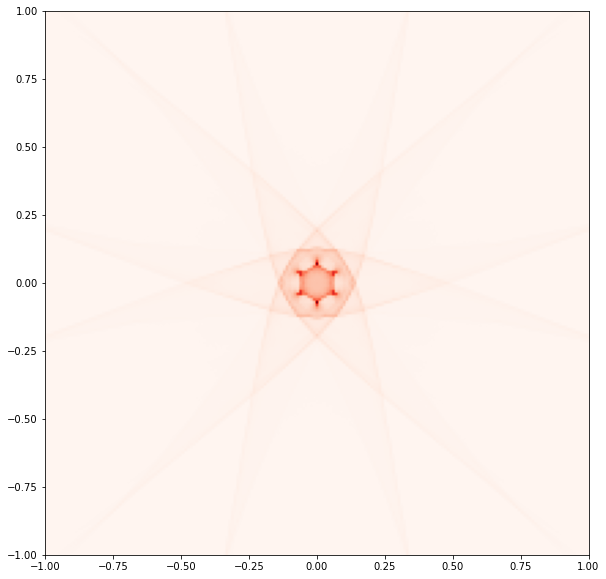

In [24]:
%matplotlib inline
r_max=1
y_vals,z_vals=results.T
valid_indices=(np.abs(y_vals)<r_max) & (np.abs(z_vals)<r_max)
y_vals=y_vals[valid_indices]
z_vals=z_vals[valid_indices]
bins=np.linspace(-r_max,r_max,200)
image,_,_=np.histogram2d(z_vals,y_vals,bins=bins)
image=np.rot90(image)
extent=[bins.min(),bins.max(),bins.min(),bins.max()]
plt.figure(figsize=(10,10))
plt.imshow(image,extent=extent,cmap='Reds')
plt.show()
save_data=np.column_stack((y_vals,z_vals))
np.save('focus_image_data',save_data)